## Hand Recognition Using Deep Learning & CNNs

In [16]:
# Let's import all the things we need
%matplotlib inline
import os
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

print(tf.__version__)

2.2.0


### Loading Data

I am using the [Hand Gesture Recognition Database](https://www.kaggle.com/gti-upm/leapgestrecog/version/1) from Kaggle. This dataset contains 20,000 images of hand gestures. It contains a total of 10 hand gestures from 10 different people, with 5 male subjects and 5 female subjects. The images were captured using the Leap Motion hand tracking device.

>Hand Gesture | Label used
>--- | ---
> Thumb down | 0
> Palm (Horizontal) | 1
> L | 2
> Fist (Horizontal) | 3
> Fist (Vertical) | 4
> Thumbs up | 5
> Index | 6
> OK | 7
> Palm (Vertical) | 8
> C | 9

Classification used for the different hand gestures.

In [5]:
image_paths = []
for root, dirs, files in os.walk(".", topdown=False):
    for name in files:
        path = os.path.join(root, name)
        if path.endswith("png"):
            image_paths.append(path)
print(len(image_paths))

20000


In [8]:
# Function used to show results and debug 

def plot_image(path):
    img = cv2.imread(path) # This will read the image into a numpy.array
    img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into correct colorspace (RGB)
    print(img_cvt.shape)
    plt.grid(False) # No grid to see better
    plt.imshow(img_cvt)
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.title("Image " + path)

(240, 640)


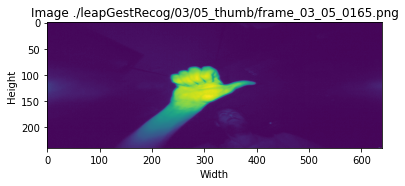

In [9]:
plot_image(image_paths[0])

Let's train the algorithm now that we've loaded the images and checked that the dataset is correct. Still have to load the images into and array X for the image data and Y for the labels.

In [13]:
X = []
y = []

for path in image_paths:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (320, 120)) # Reduce image size to speed up training
    X.append(img)
    
    # Process the labe in image path
    category = path.split('/')[3]
    # We need to convert 10_down to 00_down or else it will crash
    label = int(category.split("_")[0][1])
    y.append(label)
    
# np.array to speed up train_test_split
X = np.array(X, dtype="uint8")
X = X.reshape(len(image_paths), 120, 320, 1) # Reshape so CNN knows it's different images
y = np.array(y)

print("Images loaded: ", len(X))
print("Labels loaded: ", len(y))

print(y[0], image_paths[0])

Images loaded:  20000
Labels loaded:  20000
5 ./leapGestRecog/03/05_thumb/frame_03_05_0165.png


Using Scipy's train_test_split, we can split out data into a training set and a test set. Training will be used to build the model, and then the test data will be used to check the model performance. We use a random_state seed so the randomness of our results can be reproduced. The function will also shuffle the images it is using to minimize training loss.

In [14]:
ts = 0.3 # Let's use 30% of the images for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)

### Creating the Model
A CNN is a Deep Learning algorithm that takes in an input image, and extracts features of images to be able to differentiate one from another. A ConvNet requires much lower amounts of pre-processing compared to other classification algorithms.

In [23]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten

CNNs are the current state-of-the-art model architecture for image recognition tasks (classification). CNNs apply multiple filters to the raw pixel data of a given image to extract/learn features, which they then use for classification.

CNNs contains three components:

- Convolutional layers, which apply a specified number of convolution filters to the image. For each subregion, the layer performs a set of mathematical operations to produce a single value in the output feature map. Convolutional layers then typically apply a ReLU activation function to the output to introduce nonlinearities into the model.

- Pooling layers, which downsample the image data extracted by the convolutional layers to reduce the dimensionality of the feature map in order to decrease processing time. A commonly used pooling algorithm is max pooling, which extracts subregions of the feature map (e.g., 2x2-pixel tiles), keeps their maximum value, and discards all other values.

- Dense (fully connected) layers, which perform classification on the features extracted by the convolutional layers and downsampled by the pooling layers. In a dense layer, every node in the layer is connected to every node in the preceding layer.

https://www.tensorflow.org/tutorials/estimators/cnn

In [25]:
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(120, 320, 1))) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

Our Convolutional Neural Network consists of different layers that have different functions. As explained before, the Conv2D layer performs a 2-D convolutional operation, which can be basically interpreted as a mathematical operation to calculate weights inside the image. In order to maximize the network's performance, we need to understand the parameters required by them.

The first required by the Conv2D layer is the number of filters that the convolutional layer will learn. Layers early in the network architecture (closer to the actual input image) learn fewer convolutional filters while layers deeper in the network (closer to the output predictions) will learn more filters. This permits information to flow through the network without loss. These filters emulate edge detectors, blob detectors and other feature extraction methods.
It is necessary to tune the values of the filters, but it is common practice to use powers of 2, starting with 32, 64, 128 and increasing to 256, 512, 1024, for example.

<img src="https://www.researchgate.net/profile/Ihab_S_Mohamed/publication/324165524/figure/fig3/AS:611103423860736@1522709818959/An-example-of-convolution-operation-in-2D-2.png" alt="Example of 2D Convolution operation" width="500">

Example of 2D convolution operation.

Another parameter required by the Conv2D layer is the kernel_size, a 2-tuple specifying the width and height of the 2D convolution window. The kernel_size must be an odd integer, with typical values of (1, 1) , (3, 3) , (5, 5) , (7, 7) . It’s rare to see kernel sizes larger than 7×7. If the input images are greater than 128×128 it is recommended to test a kernel size > 3 to help learn larger spatial filters and to help reduce volume size.

Then, MaxPooling2D is used to reduce the spatial dimensions of the output volume. It reduces processing time and allows assumptions to be made about features contained in the sub-regions binned. It is possible to notice in this network that our output spatial volume is decreasing and our number of filters learned is increasing. This is a common practice in designing CNN architectures.

Finally, ReLU stands for rectified linear unit, and is a type of activation function. ReLU is the most commonly used activation function in neural networks, especially in CNNs. ReLU is linear (identity) for all positive values, and zero for all negative values. This means that it's cheap to compute as there is no complicated math. The model can therefore take less time to train or run. Also, it converges faster by applying non-linearities to the model, so there is no 'vanishing gradient problem' suffered by other activation functions like sigmoid or tanh.

In the end, there is a lot of trial and error to get the best parameters and network architecture.

In [26]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
model.fit(X_train, y_train, epochs=5, batch_size=64, 
          verbose=2, validation_data=(X_test, y_test))

Epoch 1/5
219/219 - 301s - loss: 0.0760 - accuracy: 0.9779 - val_loss: 0.0115 - val_accuracy: 0.9988
Epoch 2/5
219/219 - 295s - loss: 0.0130 - accuracy: 0.9971 - val_loss: 0.0158 - val_accuracy: 0.9955
Epoch 3/5
219/219 - 276s - loss: 0.0114 - accuracy: 0.9969 - val_loss: 0.0053 - val_accuracy: 0.9990
Epoch 4/5
219/219 - 272s - loss: 6.5104e-04 - accuracy: 0.9998 - val_loss: 0.0070 - val_accuracy: 0.9988
Epoch 5/5
219/219 - 277s - loss: 5.1770e-04 - accuracy: 0.9999 - val_loss: 0.0034 - val_accuracy: 0.9990


In [29]:
model.save('handrecognition_model.h5')

### Testing the Model
After we've compiled and trained the model, we can test it to check it's performance.

In [33]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy: {:2.2f}%'.format(test_acc*100))

188/188 [==============================] - 28s 151ms/step - loss: 0.0034 - accuracy: 0.9990
Test accuracy: 99.90%


In [38]:
predictions = model.predict(X_test) # Make predictions towards the test set

In [41]:
def validate_9_images(predictions_array, true_label_array, img_array):
  # Array for pretty printing and then figure size
  class_names = ["down", "palm", "l", "fist", "fist_moved", "thumb", "index", "ok", "palm_moved", "c"] 
  plt.figure(figsize=(15,5))
  
  for i in range(1, 10):
    # Just assigning variables
    prediction = predictions_array[i]
    true_label = true_label_array[i]
    img = img_array[i]
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    plt.subplot(3,3,i)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(prediction) # Get index of the predicted label from prediction
    
    # Change color of title based on good prediction or not
    if predicted_label == true_label:
      color = 'green'
    else:
      color = 'red'

    plt.xlabel("Predicted: {} {:2.0f}% (True: {})".format(class_names[predicted_label],
                                  100*np.max(prediction),
                                  class_names[true_label]),
                                  color=color)
  plt.show()

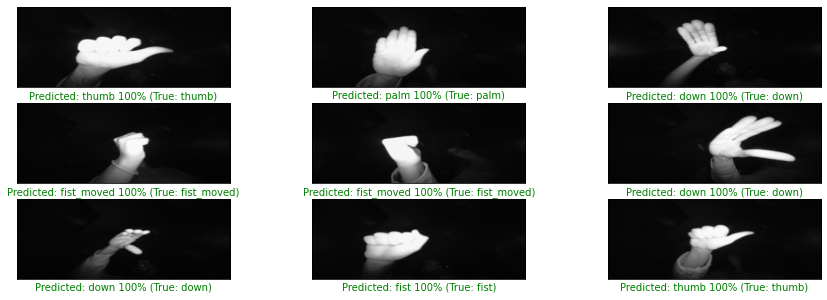

In [42]:
validate_9_images(predictions, y_test, X_test)

In [43]:
y_pred = np.argmax(predictions, axis=1)

In [44]:
# H = Horizontal, V = Vertical

pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=["Predicted Thumb Down", "Predicted Palm (H)", "Predicted L", "Predicted Fist (H)", "Predicted Fist (V)", "Predicted Thumbs up", "Predicted Index", "Predicted OK", "Predicted Palm (V)", "Predicted C"],
             index=["Actual Thumb Down", "Actual Palm (H)", "Actual L", "Actual Fist (H)", "Actual Fist (V)", "Actual Thumbs up", "Actual Index", "Actual OK", "Actual Palm (V)", "Actual C"])

,Predicted Thumb Down,Predicted Palm (H),Predicted L,Predicted Fist (H),Predicted Fist (V),Predicted Thumbs up,Predicted Index,Predicted OK,Predicted Palm (V),Predicted C
Actual Thumb Down,596,0,0,0,0,0,0,0,0,0
Actual Palm (H),0,591,0,0,0,0,0,0,0,0
Actual L,2,0,609,0,0,0,0,0,0,0
Actual Fist (H),0,0,0,621,0,0,0,0,0,0
Actual Fist (V),0,0,0,0,604,0,0,0,0,0
Actual Thumbs up,0,0,0,0,0,604,1,0,0,0
Actual Index,0,0,0,1,0,0,585,0,0,0
Actual OK,0,0,0,0,0,0,0,568,0,0
Actual Palm (V),0,0,0,0,0,0,0,0,600,0
Actual C,0,0,1,0,0,0,0,0,1,616


### Conclusion
As you can see in the results, the algorithm successfully classifies different hand gestures based on a Deep Learning model with > 99% accuracy in this dataset.

The accuracy of our model is directly influenced by our problem however.
- The gestures given are very clear and distinct, without any backgrund.
- The dataset is quite large, making the model more robust.

Nonetheless, it does a great job at classifying the gestures!